# Table of Contents

1. [Introduction](#introduction)
2. [Notebook settings](#notebook-settings)
3. [A/B Testing Goals](#ab-testing-goals)
4. [Data Loading and Verification](#data-loading-and-verification)
5. [EDA](#eda)
   1. [Retention 1 Analysis](#retention-1-analysis)
   2. [Retention 7 Analysis](#retention-7-analysis)
6. [Decision Making](#decision-making)

## Introduction
Cookie Cat is a hugely popular mobile puzzle game developed by Tactile Entertainment.<br/>
The goal for this project is to analyze the `Cookie Cats` dataset and apply A/B testing to check the player's engagement and see the retetion period effect compared for each level either `gate 30` or `gate 40` to conclude which is more effective.<br/> I will examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

The dataset contains the following columns:

For the usage purposes and guidance, this project is structured as described below:
|Columns|Description  | Datatypes       |  Count   |
|--|--|--|--|
| userid | A unique number that identifies each player | int64 | 90189  |
| version | Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40) | object | 90189  |
| sum_gamerounds | the number of game rounds played by the player during the first 14 days after install  | int64  | 90189  |
| retention_1 | Did the player come back and play 1 day after installing? | bool  | 90189  |
| retention_7 | Did the player come back and play 7 days after installing? | bool  | 90189  |


## Notebook settings

In [1]:
from assets.utils.functions import *

In [2]:
%load_ext pycodestyle_magic
#%reload_ext pycodestyle_magic
%pycodestyle_on
%flake8_on
%flake8_on --max_line_length 79
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency

## A/B Testing Goals
1. Goal and Context
Objective: Check the player's engagement and see the retetion period effect compared for each level either `gate 30` or `gate 40` to conclude which is more effective.

- Context:  When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. By analyzing this data, we aim to identify which strategy for placing the first gate is more effective in terms of player engagement and retention. 
  - Control group: The time gate is located at level 30. We are going to consider this one as a no-treatment group.
  - Treatment group: The company plans to move the time gate to level 40.


1. Target Metrics
- `sum_gamerounds`: This metric represents the total number of game rounds played by a player after installing the game. It is a direct measure of player engagement, as higher values indicate that players are playing more rounds of the game, suggesting higher engagement.
- `retention_1`: This boolean metric indicates whether a player came back to play the game 1 day after installing it. This is a short-term retention metric, useful for understanding initial player engagement and the immediate impact of the gate placement.
- `retention_7`: Similar to retention_1, this boolean metric indicates whether a player returned to play the game 7 days after installing it. This is a long-term retention metric, providing insights into the sustained interest and engagement of players over a longer period.

## Data Loading and Verification

In [4]:
cocats_df = pd.read_csv("./assets/data/cookie_cats.csv")
cocats_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
check_data_quality(cocats_df)

Missing Values:
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Non-null Counts:
userid            90189
version           90189
sum_gamerounds    90189
retention_1       90189
retention_7       90189
dtype: int64

Number of duplicate rows: 0


In [6]:
dataframe_info(cocats_df)

DataFrame Shape:
(90189, 5)

Column Names:
Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

Data Types:
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Summary Stats:
           userid  sum_gamerounds
count    90189.00        90189.00
mean   4998412.23           51.87
std    2883285.61          195.05
min        116.00            0.00
25%    2512230.00            5.00
50%    4995815.00           16.00
75%    7496452.00           51.00
max    9999861.00        49854.00


In [7]:
# Check uique values from object type columns
check_unique_values(cocats_df, 'version')

Unique values in column 'version':
['gate_30' 'gate_40']


By looking to the `max` at the Summary Stats, we can see there is a total  of 49854 game rounds played by a user in 14 days. This is a very high number, and it is likely that this user is an outlier.<br/>So lets find the user and take a decision about what to do from here.

In [8]:
# Find user with sum_gamerounds = 49854
user_with_max_gamerounds = cocats_df[cocats_df[
    'sum_gamerounds'] == 49854]['userid'].values[0]
print(f"User with sum_gamerounds = 49854: {user_with_max_gamerounds}\n")

# Filter the DataFrame for rows where userid equals 6390605
records_for_user = cocats_df.loc[cocats_df['userid'] == 6390605]

# Print the filtered records
print(records_for_user)

User with sum_gamerounds = 49854: 6390605

        userid  version  sum_gamerounds  retention_1  retention_7
57702  6390605  gate_30           49854        False         True


To compare the above result with next max game rounds played below this outlier, I want to retrieve the 2nd highest game rounds played by a user in 14 days.

In [9]:
# Sort DF by 'sum_gamerounds'
sorted_df = cocats_df.sort_values(by='sum_gamerounds')

# Remove the last entry (outlier)
sorted_df_without_outlier = sorted_df[:-1]

# Maximum value of 'sum_gamerounds' - without the outlier
new_max_sum_gamerounds = sorted_df_without_outlier['sum_gamerounds'].max()

print(f"The max game rounds without the outlier is: {new_max_sum_gamerounds}")

The max game rounds without the outlier is: 2961


## Outlier Analysis Conclusion and Action Plan
Since it is highly improbable that a user can play a game for 49854 rounds during a 14-day period, which would be 3561 rounds in a day, meaning 148 rounds per hour, considering this user would have to play for 24 hours straight, the only explanations for this situation are that the user is a "bot," a "bug," or a system failure.<br/> 
As we can see above, the highest number of game rounds a user plays within 14 days (below the outlier) is 2961, meaning approximately 212 rounds per day, leading to roughly 9 rounds per hour considering this user would have to play for 24 hours straight. Still high, but closest to reality.<br/>

Therefore, we will remove this data point from the dataset before proceeding with the analysis.

In [10]:
cocats_df = cocats_df[cocats_df['sum_gamerounds'] < 49854]

In [11]:
dataframe_info(cocats_df)

DataFrame Shape:
(90188, 5)

Column Names:
Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

Data Types:
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Summary Stats:
           userid  sum_gamerounds
count    90188.00        90188.00
mean   4998396.80           51.32
std    2883297.87          102.68
min        116.00            0.00
25%    2512211.25            5.00
50%    4995804.00           16.00
75%    7496460.75           51.00
max    9999861.00         2961.00


It looks the dataset is clean and ready to be used for analysis.<br/> The dataset contains 90188 rows (with outlier removed) and 5 columns. <br/>Also, it appears that the dataset contains no missing values, NaN's and no duplicates.

## EDA

## Game Rounds Played Distribution

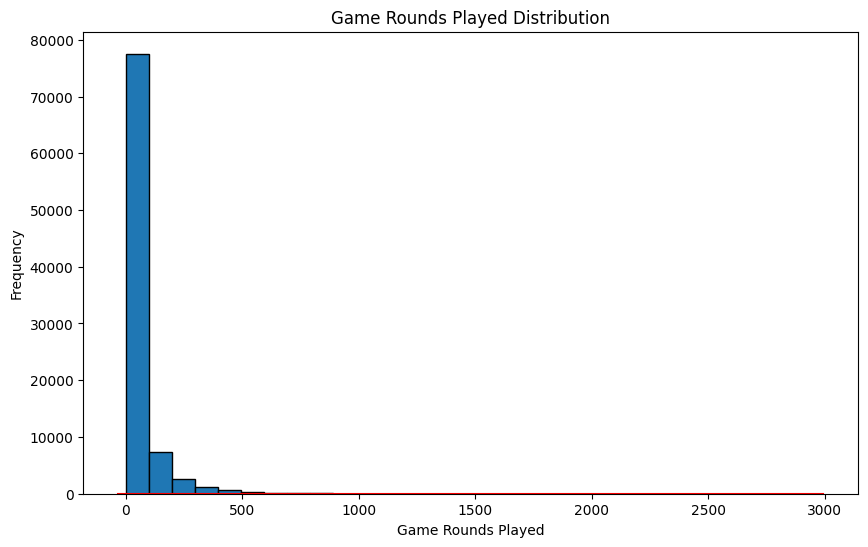

In [12]:
# Assuming cocats_df is defined and contains 'sum_gamerounds'
sum_gamerounds = pd.Series(cocats_df['sum_gamerounds'])

plt.figure(figsize=(10, 6))
plt.hist(cocats_df['sum_gamerounds'], bins=30, edgecolor='black')
sns.kdeplot(sum_gamerounds.to_numpy(), color='red')

plt.xlabel('Game Rounds Played')
plt.ylabel('Frequency')
plt.title('Game Rounds Played Distribution')
plt.show()

In [13]:
analyze_game_rounds(cocats_df)

 As we see, 99.05% of our data is below 500 Game Rounds.
 The 95 percentile of the data is at: 221.0 Game Rounds. 
 This means 85706 players are under this range.


In [14]:
summarize_player_activity(cocats_df)

Total Players: 90188, without the outlier already removed.
Total Inactive Players: 3994, with no rounds played.
Total Active Players: 86194, with more than 1 rounds played.
Average Game Rounds Played by Active Players: 53.70


The amount of 85706 players can be seen as a god sample to work with, since we are aiming to compare the player engagement and retention for each level either `gate 30` or `gate 40` to conclude which is more effective.

Text(0.5, 1.0, 'Game rounds played during first 14 days')

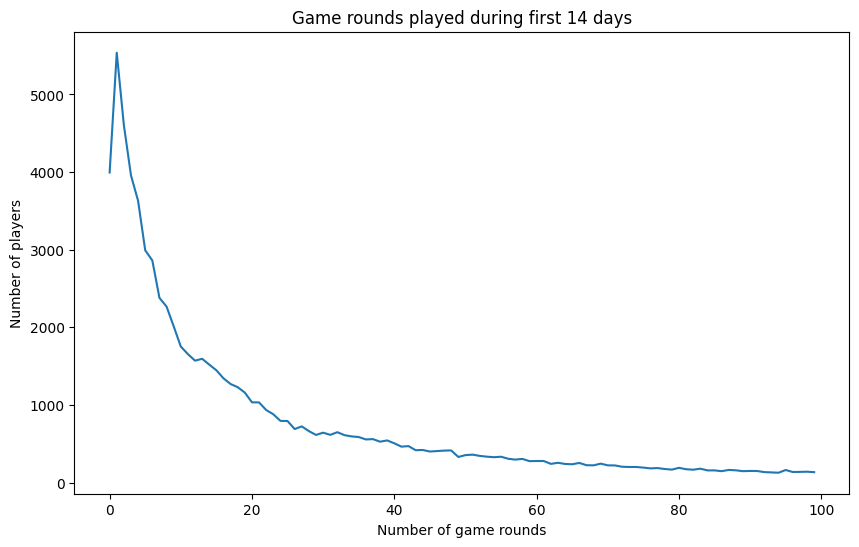

In [15]:
# Plot distribution of game rounds
df_plot = cocats_df.groupby('sum_gamerounds').count().reset_index()
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='sum_gamerounds', y='userid', data=df_plot.head(n=100))
ax.set_xlabel('Number of game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Game rounds played during first 14 days')

We can see that the distribution of game rounds played by users is highly right-skewed, with most users playing fewer rounds and a few users playing a large number of rounds. This is expected in games, as most users may play a few rounds and then stop playing, while a few users may become highly engaged and play many rounds.

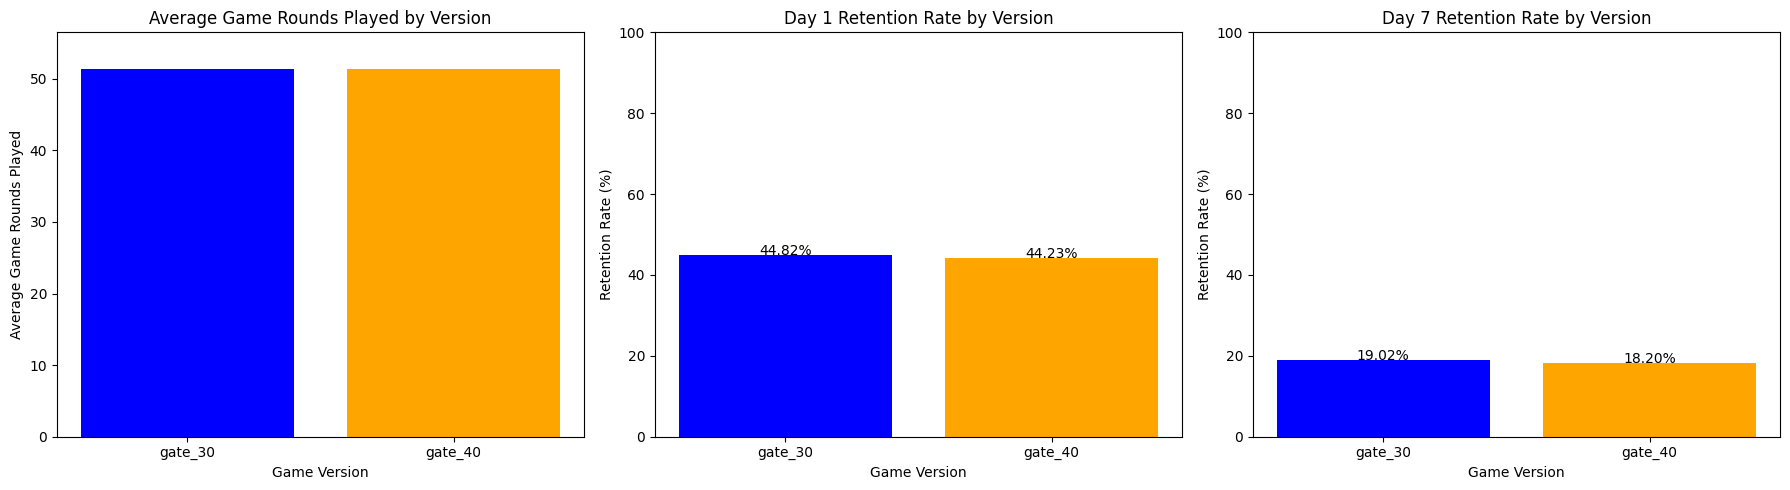

In [16]:
plot_game_data(cocats_df)

As seen above, the average number of game rounds played by users is above 50 for both gate_30 and gate_40 groups. This suggests that, on average, users play more than 50 rounds of the game during the first 14 days after installing it. And by looking at the retention rates, we can see that the 1-day retention rate is around 44% for both groups, while the 7-day retention rate is around 19% for both groups. This indicates that a higher percentage of users return to play the game 1 day after installing it compared to 7 days after installing it.<br/>

To get a better understanding of each retention period, we can deep dive into the retention rates for each group and compare them to see if there are any significant differences between the two groups and also perform bootstrap analysis to get a better understanding of the differences between the two groups.

## Retention 1 Analysis

In [17]:
percent_retention(cocats_df, 'retention_1')

The overall retention for 1 day(s) by version is:
version
gate_30    44.82%
gate_40    44.23%
Name: retention_1, dtype: object


We can see that less than a half (50%) come back to play the game 1 day after installing it. This is a relatively low retention rate, indicating that many players do not return to play the game after the first day. This could be due to various factors, such as the game not being engaging enough, the player losing interest, or other reasons.<br/>

Also, the output above shows there seems to be a slight drop in 1-day retention when comparing the gate 40 (44.23%) and gate 30 (44.82%). 

## Bootstrapping for 1-day Retention
While the difference in 1-day retention between the two groups is small, it is important to determine whether this difference is statistically significant. To do this, we will use bootstrapping to simulate the sampling distribution of the difference in 1-day retention between the two groups and calculate the p-value.

In [18]:
# Bootstrap analysis for retention_1
iterations = 10000  # Number of bootstrap samples
bs_replicates = draw_bs_reps(df=cocats_df,
                             column='retention_1',
                             func=retention,
                             iterations=iterations)

# Stats on bs_replicates, such as the mean and confidence intervals
mean_retention = np.mean(bs_replicates)
conf_interval = np.percentile(bs_replicates, [2.5, 97.5])
print(f"Mean retention: {mean_retention}")
print(f"95% confidence interval: {conf_interval}")

Mean retention: 0.44524557923448793
95% confidence interval: [0.44207655 0.44847458]


In [19]:
ttest_compare_retention(cocats_df, 'version', 'retention_1')

T-statistic: 1.787115337299244
P-value: 0.07392220630182518
There is no statistically significant difference in retention rates between gate_30 and gate_40.


## Conclusion Rentention 1 Analysis
- Bootstrap Analysis: The mean retention rate derived from the bootstrap method is 44.52%, with a 95% confidence interval ranging from 44.20% to 44.84%.<br/> This confidence interval provides a range of plausible values for the true mean retention rate in the population, based on the sample data.

- T-Test Results:

  - T-Statistic: The t-statistic of 1.787 indicates the direction and magnitude of the difference between the two groups' mean retention rates, with a positive value suggesting that gate_30 has a higher mean retention rate than gate_40.<br/>
  - P-Value: The p-value of 0.0739 exceeds the common alpha level of 0.05, which suggests that the observed difference in retention rates between gate_30 and gate_40 is not statistically significant at the 5% significance level.<br/>
  
### Conclusion:
 Although gate_30 shows a slightly higher retention rate than gate_40 after 1 day, the difference is not statistically significant. This means that, based on the data and analyses conducted, there is not enough evidence to conclude that the placement of the gate at level 30 or level 40 has a significant impact on player retention after 1 day. Decisions on gate placement should consider other factors as well, such as player engagement, progression speed, and overall game balance.

## Retention 7 Analysis

In [20]:
percent_retention(cocats_df, 'retention_7')

The overall retention for 7 day(s) by version is:
version
gate_30    19.02%
gate_40     18.2%
Name: retention_7, dtype: object


The retention rate for users with gate_30 is 19.02%, compared to 18.2% for users with gate_40. This indicates that a slightly higher percentage of users continued to use the app after 7 days when the gate was placed at level 30 instead of level 40. <br/> WE can also see the difference is larger than retention 1.

## Bootstrapping for 7-day Retention
While the difference in 7-day retention between the two groups is small, but larger than 1 day retention, it is important to determine whether this difference is statistically significant. I will also appply bootstrapping to simulate the sampling distribution of the difference in 7-day retention between the two groups and calculate the p-value.

In [21]:
# Bootstrap analysis for retention_7
iterations = 10000  # Number of bootstrap samples
bs_replicates = draw_bs_reps(df=cocats_df,
                             column='retention_7',
                             func=retention,
                             iterations=iterations)

# Stats on bs_replicates, such as the mean and confidence intervals
mean_retention = np.mean(bs_replicates)
conf_interval = np.percentile(bs_replicates, [2.5, 97.5])
print(f"Mean retention: {mean_retention}")
print(f"95% confidence interval: {conf_interval}")

Mean retention: 0.18606312147957602
95% confidence interval: [0.18350557 0.18862848]


In [22]:
ttest_compare_retention(cocats_df, 'version', 'retention_7')

T-statistic: 3.1575495965685936
P-value: 0.001591535729785478
There is a statistically significant difference in retention rates between gate_30 and gate_40.


## Conclusion Rentention 7 Analysis
- Bootstrap Analysis: The mean retention rate derived from the bootstrap method is 18.60%, with a 95% confidence interval ranging from 18.35% to 18.86%.<br/> Which means on average, about 18.60% of players continue to engage with the game 7 days after installation.

- T-Test Results:

  - T-Statistic: The t-statistic of 3.157 indicates the direction and magnitude of the difference between the two groups' mean retention rates, with a positive value suggesting that gate_30 has a higher mean retention rate than gate_40.<br/>
  - P-Value: The p-value of 0.0016 is less than the commonly used significance level of 0.05, indicating that the observed difference in 7-day retention rates between the two versions is statistically significant.<br/>
  
### Conclusion:
 The analysis conclusively shows that there is a statistically significant difference in 7-day retention rates between gate_30 and gate_40. This suggests that the placement of the gate within the game has a significant impact on whether players continue to engage with the game a week after first playing it. Given the statistical significance, game developers should consider the placement of such gates carefully, as it can influence player retention.

## Decision Making
Based on the comprehensive analysis of the data provided, we can draw several conclusions regarding the impact of gate placement (at level 30 vs. level 40) in the game on player retention rates at both 1-day and 7-day intervals.

- Retention Rates:

  - For the 1-day retention, the rates are 44.82% for gate_30 and 44.23% for gate_40. This difference is not statistically significant, as indicated by a p-value of 0.0739, suggesting that the gate placement does not significantly affect player retention after 1 day.<br/>
  - For the 7-day retention, the rates are 19.02% for gate_30 and 18.2% for gate_40. The difference here is statistically significant, with a p-value of 0.0016, indicating that placing the gate at level 30 leads to slightly better retention after 7 days compared to placing it at level 40.<br/>
  
- Bootstrap Analysis:

  - The bootstrap results for the mean retention and the 95% confidence intervals provide additional support to the findings from the t-tests. The confidence intervals do not overlap between the two versions for the 7-day retention rate, further confirming the statistical significance of the difference observed.<br/>
  
- Game Rounds Played:

The analysis of game rounds played shows a wide distribution of player engagement, with a significant majority (99.05%) playing fewer than 500 rounds within the first 14 days.<br/> 

- Player Engagement:

The data on total players, inactive players, and active players, along with the average game rounds played by active players, provides a broader context for understanding player engagement and retention. The high level of initial engagement (as indicated by the average game rounds played) contrasts with the drop in retention rates, highlighting the challenge of maintaining long-term engagement.<br/>


- Overall Conclusion:<br/> 
  - The placement of the gate at level 30 appears to have a positive impact on player retention after 7 days, as opposed to placing it at level 40. However, the effect size is modest, and the decision on gate placement should also take into account other aspects of game design and player experience.<br/>